# Animation of bioRSP algorithm
This notebook provides a nice visual of how the CDFs are computed for different angles and how the scanning window is computed. The animation is done using the `matplotlib` library, and the GIF is saved in the `animations` folder.

In [21]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from ipynb.fs.full.biorsp import (
    find_foreground_background_points,
    convert_to_polar,
    in_scanning_range,
    compute_cdfs,
    compute_area,
)

In [22]:
os.makedirs("animations", exist_ok=True)

In [23]:
# Load your data
dge_matrix = pd.read_csv("data/MCA2_filtered.dge.txt", sep="\t", index_col=0)
tsne_results = pd.read_csv("embeddings/tsne_results.csv").to_numpy()
dbscan_results = pd.read_csv("embeddings/tsne_dbscan_results.csv")

In [24]:
# Define parameters
gene_name = "Tnnt2"
threshold = 10
clusters = [1]
scanning_window = np.pi
num_scanning_angles = 360  # Number of frames in animation
num_bins_within_window = 1000  # Number of bins within scanning window
angle_range = np.array([0.0, 2.0 * np.pi])
mode = "absolute"

In [25]:
# Find foreground and background points
foreground_points, background_points = find_foreground_background_points(
    gene_name=gene_name,
    dge_matrix=dge_matrix,
    tsne_results=tsne_results,
    threshold=threshold,
    dbscan_df=dbscan_results,
    selected_clusters=clusters,
)

In [26]:
# Set the vantage point
vantage_point = background_points.mean(axis=0)

In [27]:
# Convert points to polar coordinates
fg_r, fg_theta = convert_to_polar(foreground_points, vantage_point)
bg_r, bg_theta = convert_to_polar(background_points, vantage_point)

In [28]:
# Calculate scanning angles
theta_min = angle_range[0]
theta_max = angle_range[1]
theta_k_list = (
    theta_min
    + np.arange(num_scanning_angles) * (theta_max - theta_min) / num_scanning_angles
)

# Determine the maximum radius for the scanning window
radius_max = max(np.max(fg_r), np.max(bg_r))

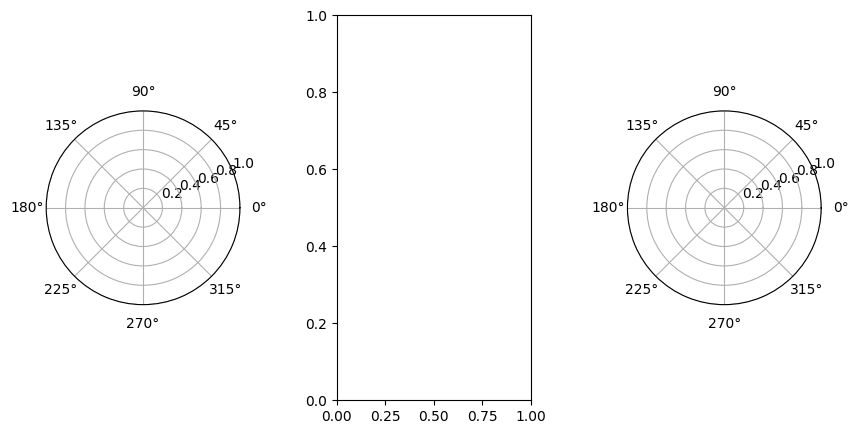

In [29]:
# Set up the figure and axes for animation with square plots
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.5)
ax1 = fig.add_subplot(gs[0], projection="polar")
ax2 = fig.add_subplot(gs[1])


# Function to plot the scanning window on the polar plot
def plot_scanning_window(ax, start_angle, end_angle, radius_max):
    # Handle wrap-around
    if start_angle < end_angle:
        theta_window = np.linspace(start_angle, end_angle, 100)
    else:
        # Wrap-around case
        theta_window = np.linspace(start_angle, end_angle + 2 * np.pi, 100)
        theta_window = theta_window % (2 * np.pi)
    # Create the corresponding r values
    r_window = np.full_like(theta_window, radius_max)
    # Add the origin to close the polygon
    theta_polygon = np.concatenate(
        ([start_angle], theta_window, [end_angle], [start_angle])
    )
    r_polygon = np.concatenate(([0], r_window, [0], [0]))
    # Plot the scanning window
    ax.fill(theta_polygon, r_polygon, color="yellow", alpha=0.3)


def animate(i):
    angle = theta_k_list[i]
    theta_shift = angle - scanning_window / 2
    start_angle = theta_shift % (2 * np.pi)
    end_angle = (theta_shift + scanning_window) % (2 * np.pi)

    ax1.clear()
    ax2.clear()

    # Radar scanning demo (Left Side) - Polar Plot
    # Plot background points
    ax1.scatter(bg_theta, bg_r, color="grey", s=1, label="Background")
    # Plot foreground points
    ax1.scatter(fg_theta, fg_r, color="red", s=1, label="Foreground")

    # Highlight scanning window
    plot_scanning_window(ax1, start_angle, end_angle, radius_max)

    ax1.set_ylim(0, radius_max)
    ax1.set_title(f"Scanning Angle: {np.degrees(angle):.2f}°")
    # Show gridlines and spines
    ax1.grid(True)
    # Set tick marks
    ax1.set_xticks(np.linspace(0, 2 * np.pi, 8, endpoint=False))  # Every 45 degrees
    ax1.set_yticks(np.linspace(0, radius_max, 5))
    ax1.legend(loc="upper right", bbox_to_anchor=(1.1, 1.1))

    # Compute CDFs for the current scanning window using provided functions
    fg_in_window = in_scanning_range(fg_theta, angle, scanning_window)
    bg_in_window = in_scanning_range(bg_theta, angle, scanning_window)

    fg_projection = fg_theta[fg_in_window]
    bg_projection = bg_theta[bg_in_window]

    # Use provided functions to compute histograms and CDFs
    fg_cdf, bg_cdf = compute_cdfs(
        fg_projection,
        bg_projection,
        angle,
        scanning_window,
        num_bins_within_window,
        mode,
    )

    # Prepare bin edges and centers
    bin_edges = np.linspace(0.0, scanning_window, num_bins_within_window + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # CDFs plot (Right Side)
    if np.any(bg_cdf):
        # Plot background CDF and fill area under the curve
        ax2.fill_between(
            bin_centers,
            0,
            bg_cdf,
            step="mid",
            color="grey",
            alpha=0.5,
            label="Background CDF",
        )
        ax2.plot(bin_centers, bg_cdf, color="grey")

    if np.any(fg_cdf):
        # Plot foreground CDF and fill area under the curve
        ax2.fill_between(
            bin_centers,
            0,
            fg_cdf,
            step="mid",
            color="red",
            alpha=0.5,
            label="Foreground CDF",
        )
        ax2.plot(bin_centers, fg_cdf, color="red")

    # Handle case when there is no foreground data
    if not np.any(fg_cdf):
        ax2.text(
            0.5,
            0.5,
            "No Foreground Data in this window",
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax2.transAxes,
        )

    ax2.legend()
    ax2.set_xlabel("Theta (radians)")
    ax2.set_ylabel("CDF")
    ax2.set_title("CDFs within Scanning Window")
    ax2.set_xlim(0, scanning_window)
    ax2.set_ylim(0, 1)
    ax2.grid(True)
    # Ensure the right plot is square
    ax2.set_aspect(aspect="equal", adjustable="box")

In [30]:
# Create the animation
anim = FuncAnimation(fig, animate, frames=num_scanning_angles, interval=100)

# Save the animation as a GIF
anim.save(f"animations/{gene_name}_rsp_animation.gif", writer="pillow", fps=10)

# To display the animation in the notebook (uncomment if needed)
# from IPython.display import HTML
# HTML(anim.to_jshtml())

IndexError: list index out of range